References:
- https://github.com/pyg-team/pytorch_geometric
- https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
- https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=imGrKO5YH11-

KNOWN_BUGS:
- Component Layer doesn't currently account for through hole components w/ pads on the opposite side. This is because I am throwing away pad info and just using component outline info.
- Board Outline is currently ignored
- Not currently exporting/using non-designator text

TODO:
- Update categorical handling to automatically handle any number of categorical features
- If I get this architecture making descent predictions, I need to predict silkscreen sizes and not just have them be static
  
NOTES:
- Cadence doesn't seem to have any standard for naming silk layers or artwork groups. For example silkscreen top could be used as the assembly top output to gerber or vice versa and everything in between. Also, there are 10s of silkscreen layer options. I am currently assuming the valid silk layers by searching the artwork groups for "silk" in the name or a couple of other variations that i've seen, but this is by no means a catch all solution and may need to be manually edited for each board export.
- Currently not using slk-arc in training (I don't see this being necessary until predictions become more accurate. I don't think this is a major factor holding back good predictions). I do have it's data preprocessing in this notebook, but it is not used in training.
- I created a tool embedding to feed to the network (cadence/altium), but it will still get created if only one tool is used.
- I was using PyGeometric's train/val/test mask attribute, but had to remove it because if you use DataLoader w/ mask, sometimes you will get batches of data w/ the entire mask set to False which will give nan predictions.

Tools:
- Altium export/import scripts tested w/ 22.5.1
- Cadence export script tested w/ PCB Editor v17.4

In [1]:
import sys
sys.path.insert(0, './models')

import torch
from torch_geometric.data import Data

import pandas as pd
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
from time import time
from collections import Counter

# Add project directories not tracked by git
prj_dirs = ['models']
for d in ['train','test','predictions']:
    subdir = os.path.join('data',d)
    prj_dirs += [subdir]
    
for d in prj_dirs:
    if not(os.path.exists(d)):
        os.mkdir(d)

DATA_DIR = os.path.join('data','train')
TEST_DIR = os.path.join('data','test')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

C:\Users\Steph\Anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
data_files = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
assert len(data_files) > 0, f'Add csv datasets to {DATA_DIR} before running.'
test_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.csv')]
data_files += test_files

In [3]:
data_files

['data\\train\\1.csv',
 'data\\train\\10.csv',
 'data\\train\\11.csv',
 'data\\train\\12.csv',
 'data\\train\\13.csv',
 'data\\train\\14.csv',
 'data\\train\\15.csv',
 'data\\train\\16.csv',
 'data\\train\\17.csv',
 'data\\train\\18.csv',
 'data\\train\\19.csv',
 'data\\train\\2.csv',
 'data\\train\\20.csv',
 'data\\train\\21.csv',
 'data\\train\\22.csv',
 'data\\train\\23.csv',
 'data\\train\\24.csv',
 'data\\train\\25.csv',
 'data\\train\\26.csv',
 'data\\train\\27.csv',
 'data\\train\\28.csv',
 'data\\train\\29.csv',
 'data\\train\\3.csv',
 'data\\train\\30.csv',
 'data\\train\\31.csv',
 'data\\train\\32.csv',
 'data\\train\\33.csv',
 'data\\train\\34.csv',
 'data\\train\\35.csv',
 'data\\train\\36.csv',
 'data\\train\\37.csv',
 'data\\train\\38.csv',
 'data\\train\\39.csv',
 'data\\train\\4.csv',
 'data\\train\\40.csv',
 'data\\train\\41.csv',
 'data\\train\\5.csv',
 'data\\train\\6.csv',
 'data\\train\\7.csv',
 'data\\train\\8.csv',
 'data\\train\\9.csv',
 'data\\test\\0.csv']

### Data Description:

| Column     | Type | Description |
| ----------- | ----------- | ----------- |
| Tool      | N/A     | altium/cadence|
| Type      | N/A       | Features extracted from type Silk or Pin (x/y/L/R/T/B). If Pin Type, features may be extracted from parent Component |
| Designator      | Component       | Parent Component Designator |
| x/y      | Component or Silk       | Origin Coords |
| L/R/T/B      | Component or Silk       | Bounding Rectangle (x1,x2,y1,y2 for tracks/arcs) |
| Rotation      | Component or Silk       | Degrees |
| Layer      | Component      | Top or Bottom |
| Info      | Type Specific      | Delimited list of extra info specific to Type |
| Board      | N/A     | This is not imported data. This is an index of each board/dataset |

### Info Column Specific Data

| Tool  | Info Column     | Type | Description |
| ----- | ----------- | ----------- | ----------- |
| Cadence | OriginalLayer      | All     | Original Cadence Layer Name before filtered to Top/Bottom |
| Altium | PinName      | Pin     | Pin Name |
| Cadence | PinNumber      | Pin     | Pin Number |
| Cadence | PadstackName      | Pin     | Padstack Name |
| Cadence | PinRotation      | Pin     | Rotation in Degrees |
| Cadence | PinRelativeRotation      | Pin     | Rotation in Degrees Relative to Component |
| Cadence | IsThrough      | Pin     | Is a Through Hole pin |
| Both | NetName      | Pin     | Pin's Net Name |
| Both | PinX/Y      | Pin     | Pin's Origin Coords |
| Both | Width      | Track/Arc     | Track/Arc Width |
| Altium | Length      | Track     | Track Length |
| Both | Radius      | Arc     | Radius in mils |
| Altium | StartAngle      | Arc     | Start Angle |
| Altium | EndAngle      | Arc     | End Angle |
| Cadence | IsCircle      | Arc     | CIRCLE/UNCLOSED_ARC |
| Cadence | IsClockwise      | Arc     | TRUE/FALSE |
| Both | InComponent      | Track/Arc     | Object Part of Component Footprint (0=False,-1=True) |
| Cadence | LineType      | Track     | vertical/horizontal/odd |
| Cadence | Justify      | Des     | Text Justification (CENTER,) |
| Cadence | IsMirror      | Des     | Text is mirrored (TRUE/FALSE) |

Notes: 
- units in mils
- Pin Type varies for each row (Pin/Net/PinX/PinY), but Component data is the duplicate info across these rows (x/y/L/R/T/B/Rotation/Layer).

In [4]:
# Combine all csv datasets
df_list = []
for i, file in enumerate(data_files):
    df = pd.read_csv(file)
    df['Board'] = i
    
    # Verification
    assert all([t in set(df.Type) for t in ['pin', 'slk-des']]), 'Missing data type.'
    
    df_list.append(df)

df = pd.concat(df_list, axis=0, ignore_index=True)

### Separate Tracks/Arcs from the main dataset

### Split Info Column in to Multiple Columns

In [6]:
dt = df.loc[df.Type.isin(['slk-trk','slk-arc'])] # Track/Arc Dataset
df = df.loc[~df.Type.isin(['slk-trk','slk-arc'])] # Main Dataset

In [7]:
def split_info(df):
    info_cols = set([i.split(':')[0] for row in df.Info for i in row.split(';') if i.split(':')[0] != ''])
    print(f'Info Columns: {info_cols}')

    def get_info(col, info, D=';'):
        info_dict = {i.split(':')[0]:i.split(':')[-1] for i in info.split(D)}
        return info_dict.get(col, 'NA')

    for c in info_cols:
        df[c] = df.Info.apply(lambda i: get_info(c, i))

    df.drop(columns=['Info'], inplace=True)
    
    return df

In [8]:
dt = split_info(dt)
    
dt.drop(columns=['Rotation'], inplace=True)
dt.rename(columns={'L':'x1','R':'x2','T':'y1','B':'y2'}, inplace=True)

Info Columns: {'InComponent', 'EndAngle', 'isCircle', 'Width', 'isClockwise', 'LineType', 'StartAngle', 'OriginalLayer', 'Length', 'Radius'}


C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\873560977.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df.Info.apply(lambda i: get_info(c, i))
C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\873560977.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df.Info.apply(lambda i: get_info(c, i))
C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\873560977.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [9]:
# df.loc[df.Info.isna(), 'Info'] = '' # Convert NaN to empty
# tmp = split_info(df.copy()) # Don't need the info cols for df, so just hold in tmp dataframe

# print('\nVisually verify each original layer is grouped in to the correct top or bottom layer group.')
# print('If it gets it wrong, this is defined in the cadence export script')
# tmp.loc[(tmp.Tool=='cadence'), ['Layer', 'OriginalLayer']].drop_duplicates(subset=['Layer','OriginalLayer'])

In [10]:
#del tmp

### Drop unmanufacturable track widths
note: I don't know how cadence handles silk track visibility in gerbers because not all silk tracks make it to the gerber. So I'm currently assuming anything less than 4 mils is not in the final gerber.

In [11]:
# MIN_SLK_TRK_WIDTH = 4 # mils
#dt = dt.loc[(dt.Width.astype(float) > MIN_SLK_TRK_WIDTH) | (dt.Width.astype(float) == 0)]

In [12]:
orig_len = len(df)

# Drop duplicated silkscreen designators (I dont know a clean way to know which silk to use if duplicates exist)
df = df[~((df.Type == 'slk-des') & df.duplicated(subset=['Board','Type','Designator','Layer']))]
print(f'Dropped {orig_len - len(df)} duplicates.')

Dropped 3713 duplicates.


In [13]:
# Verification
assert len(df.loc[(df.Type=='slk-des') & (df.duplicated(subset=['Board','Type','Designator','Layer']))]) == 0, "Duplicate Silk Rows"

row_cnts = df.groupby(by=['Board']).Designator.count().tolist()
if len(set(df.Board)) > 1:
    assert all([row_cnts[0] == r for r in row_cnts]) == False, 'Each board has the same number of data rows, something is probably wrong with the input data.'

In [14]:
# I'm not going to use Pin Info for this notebook (will merge duplicate pin info in to component info)
df = df[~((df.Type == 'pin') & df.duplicated(subset=['Board','Type','Designator','Layer']))]

df.drop(columns=['Info'], inplace=True)
df.loc[df.Type == 'pin', 'Type'] = 'cmp'

print(len(df))

110272


# Clean Data

In [15]:
def print_feature_distribution(feature_data, idx_to_key=None):
    probs_dict = {}
    for i, v in enumerate(list(set(feature_data))):
        probs_dict[v] = sum(feature_data == v)/len(feature_data)

    if idx_to_key:
        keys = [str(idx_to_key[i]) for i in probs_dict.keys()]
    else:
        keys = [str(k) for k in probs_dict.keys()]
        
    fig, ax = plt.subplots()
    ax.bar(keys, probs_dict.values())
    plt.show()

def categorical_encoding(data_list, thresh=0.01, drop=False):
    """
    drop: False='data values below thresh will be added to OTHER key.'
          True='data values below thresh will be excluded from encoding'
    """
    cnt = Counter(data_list) 
    valid = [k for k, v in cnt.most_common() if v/sum(cnt.values()) > thresh]
    
    if drop:
        key_to_idx = {c:i for i, c in enumerate(sorted(valid), 0)}
    else:
        key_to_idx = {} if len(cnt) == len(valid) else {'OTHER': 0}
        key_to_idx.update({c:i for i, c in enumerate(sorted(valid), len(key_to_idx))})
    
    idx_to_key = {v:k for k, v in key_to_idx.items()}
    
    if drop:
        encoding = [key_to_idx[d] for d in data_list if d in key_to_idx.keys()]
    else:
        encoding = [key_to_idx.get(d, 0) for d in data_list]
    
    return encoding, key_to_idx, idx_to_key

C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\1549986137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['X_Tool'] = [tool_to_class[t] for t in dt.Tool]
C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\1549986137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt.drop(columns=['Tool'], inplace=True)


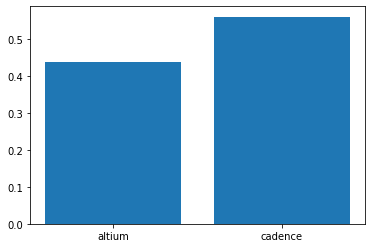

In [16]:
encoding, tool_to_class, class_to_tool = categorical_encoding(df.Tool)
df['X_Tool'] = encoding
df.drop(columns=['Tool'], inplace=True)

dt['X_Tool'] = [tool_to_class[t] for t in dt.Tool]
dt.drop(columns=['Tool'], inplace=True)

# Verification
assert set(df.X_Tool) == set(tool_to_class.values()), 'encoding mismatch'

print_feature_distribution(df.X_Tool, idx_to_key=class_to_tool)

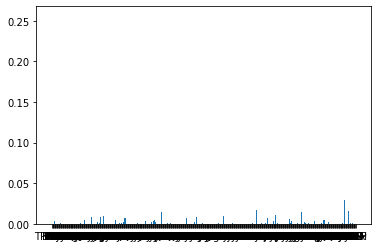

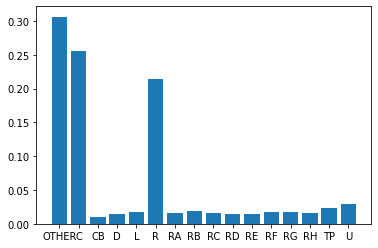

In [17]:
# Create a categorical feature from the refdes alphabetic prefix

def create_refdes_class(refdes):
    return ''.join([c for c in refdes if c.isalpha()])

df['R_DES'] = df.Designator.apply(create_refdes_class) 
print_feature_distribution(df.R_DES)

df['X_DES'], refdes_to_class, class_to_refdes = categorical_encoding(df.R_DES)
df.drop(columns='R_DES', inplace=True)

# Verification
assert set(df.X_DES) == set(refdes_to_class.values()), 'encoding mismatch'

print_feature_distribution(df.X_DES, idx_to_key=class_to_refdes)

C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\429994050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['R_DES'] = dt.Designator.apply(create_refdes_class)
C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\429994050.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['X_DES'] = [refdes_to_class.get(r, 0) for r in dt.R_DES]
C:\Users\Steph\AppData\Local\Temp\ipykernel_21684\429994050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

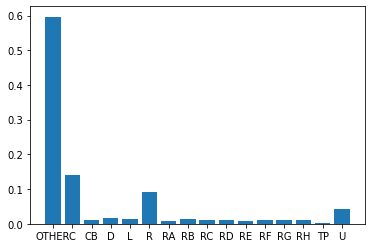

In [18]:
# Track & Arc Designator Feature
dt.loc[dt.Designator.isna(), 'Designator'] = 'OTHER'
dt['R_DES'] = dt.Designator.apply(create_refdes_class) 
dt['X_DES'] = [refdes_to_class.get(r, 0) for r in dt.R_DES]
dt.drop(columns='R_DES', inplace=True)

print_feature_distribution(dt.X_DES, idx_to_key=class_to_refdes)

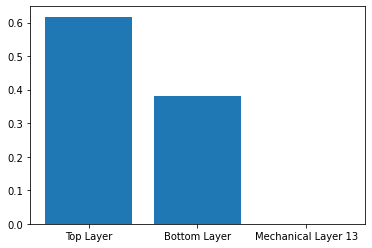

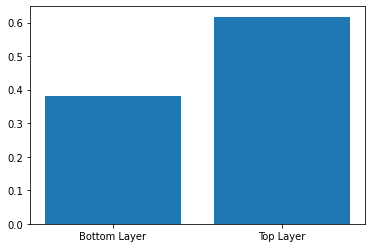

In [19]:
print_feature_distribution(df.Layer)

encoding, layer_to_class, class_to_layer = categorical_encoding(df.Layer, drop=True)
df = df.loc[df.Layer.isin(layer_to_class.keys())].copy()
df['X_Layer'] = encoding
df.drop(columns=['Layer'], inplace=True)

# Verification
assert set(df.X_Layer) == set(layer_to_class.values()), 'encoding mismatch'

print_feature_distribution(df.X_Layer, idx_to_key=class_to_layer)

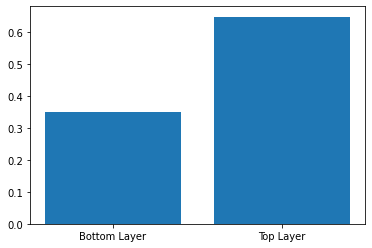

In [20]:
# Track & Arc Layer Categorical Feature
dt = dt.loc[dt.Layer.isin(layer_to_class.keys())].copy()
dt['X_Layer'] = [layer_to_class[l] for l in dt.Layer]
dt.drop(columns=['Layer'], inplace=True)

print_feature_distribution(dt.X_Layer, idx_to_key=class_to_layer)

In [21]:
# InComponent Categorical Feature
dt['X_InCmp'] = [0 if c in [0,'0'] else 1 for c in dt.InComponent]
dt.drop(columns=['InComponent'], inplace=True)

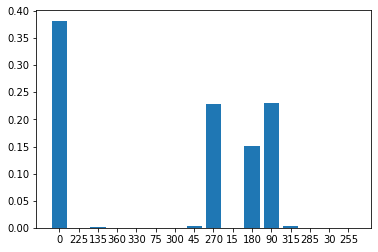

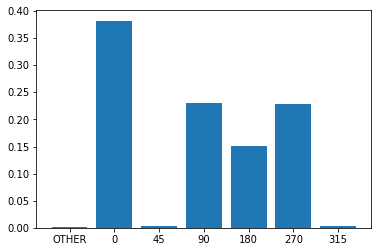

In [22]:
def round_rotations(rotation, round_degree=15):
    rotation = rotation - 360 if rotation >= 360 else rotation
    return int(np.round(rotation/round_degree)*round_degree)

df.Rotation = df.Rotation.apply(round_rotations)
print_feature_distribution(df.Rotation)

orig_len = len(df)

encoding, rotation_to_class, class_to_rotation = categorical_encoding(df.Rotation, drop=False, thresh=0.001)
#df = df.loc[df.Rotation.isin(rotation_to_class.keys())].copy()
df['XY_ROT'] = encoding
df.drop(columns=['Rotation'], inplace=True)

#print(f'Dropped {orig_len - len(df)} rows w/ infrequent rotations.')
print_feature_distribution(df.XY_ROT, idx_to_key=class_to_rotation)

In [23]:
# Separate silk and component types in to their own dataframes
df_s = df.copy().loc[df.Type == 'slk-des']
df_c = df.copy().loc[df.Type == 'cmp']

# Silk Rotation is an output feature
df_s.rename(columns={'XY_ROT': 'Y_ROT'}, inplace=True)

# Cmp Layer & Rotation are input features instead of Output Labels
df_c.rename(columns={'XY_ROT': 'X_ROT'}, inplace=True)

In [24]:
orig_len = len(df_s)

# Verification
assert set(df_s.Board) == set(df_c.Board), 'Missing data.'

# Remove rows where designator is not in both silkscreen & component datasets
for b in set(df_s.Board):
    s_des = set(df_s[df_s.Board==b].Designator)
    c_des = set(df_c[df_c.Board==b].Designator)
    
    rem = s_des.difference(c_des)
    df_s = df_s.drop(df_s[(df_s.Board==b) & (df_s.Designator.isin(rem))].index)
    
    if len(rem) > 0:
        print(f'Board: {b}, {data_files[b]}')
        print(rem)
        
print(f'Removed {orig_len-len(df_s)} rows. Best case is if this is 0.')

Removed 0 rows. Best case is if this is 0.


In [25]:
# Split track & arc datasets
da = dt.loc[dt.Type == 'slk-arc']
dt = dt.loc[dt.Type == 'slk-trk']

drops = [c for c in ['Length','Type','LineType'] if c in da.columns]
da.drop(columns=drops, inplace=True) # Remove track specific data from arc dataframe
drops = [c for c in ['StartAngle','EndAngle','Radius','Type','isCircle','isClockwise'] if c in dt.columns]
dt.drop(columns=drops, inplace=True) # ditto for arc data

# Set cadence start/end angles & length to 0 since cadence doesn't have an equivalent. 
# This is a temporary solution since this data isn't currently being used anyway
if 'StartAngle' in da.columns:
    da.loc[(da.StartAngle == 'NA'), 'StartAngle'] = 0
    da.loc[(da.EndAngle == 'NA'), 'EndAngle'] = 0
    dt.loc[(dt.Length == 'NA'), 'Length'] = 0

In [26]:
# Create node indexes
for b in set(df.Board):
    df_s.loc[df_s.Board==b, 'idx'] = [i for i in range(len(df_s.loc[df_s.Board==b]))]
    df_c.loc[df_c.Board==b, 'idx'] = [i for i in range(len(df_c.loc[df_c.Board==b]))]
    da.loc[da.Board == b, 'idx'] = [i for i in range(len(da.loc[da.Board==b]))]
    dt.loc[dt.Board == b, 'idx'] = [i for i in range(len(dt.loc[dt.Board==b]))]
    
df_s.idx = df_s.idx.astype(int)
df_c.idx = df_c.idx.astype(int)
da.idx = da.idx.astype(int)
dt.idx = dt.idx.astype(int)

### Normalize

In [27]:
SCALER = 10000

# Component Data
for c in ['x','y','L','R','T','B']:
    df_c[c] = df_c[c]/SCALER

# Silkscreen Data
df_s['W'] = abs(df_s['R'] - df_s['L'])/SCALER
df_s['H'] = abs(df_s['T'] - df_s['B'])/SCALER
df_s.drop(columns=['L','R','T','B','Type'], inplace=True)

# Track Data
for c in ['x','y','x1','x2','y1','y2','Width','Length']:
    if c in dt.columns:
        dt[c] = dt[c].astype(float)/SCALER
    
# Arc Data
for c in ['x','y','x1','x2','y1','y2','Width','Radius']:
    if c in da.columns:
        da[c] = da[c].astype(float)/SCALER

if 'StartAngle' in da.columns:
    da.StartAngle = da.StartAngle.astype(float)/360
    da.EndAngle = da.EndAngle.astype(float)/360

# Not sure if it's better to scale the output predictions
# df_s['x'] = df_s['x']/SCALER
# df_s['y'] = df_s['y']/SCALER

### Define Features

In [28]:
cmp_features = ['X_Tool','X_DES','X_Layer','X_ROT','x','y','L','R','T','B']
slk_features = ['X_Tool','X_DES','W','H']
trk_features = ['X_Tool','X_DES','X_Layer','x','y','x1','x2','y1','y2','Width']
arc_features = ['X_Tool','X_DES','X_Layer','x','y','x1','x2','y1','y2','Width','StartAngle','EndAngle','Radius']
slk_lbls = ['Y_ROT','x','y']

# Categorical Pin Features
categorical_cmp_features = [c for c in df_c.columns if 'int' in str(df_c[c].dtype) and c in cmp_features]
categorical_slk_features = [c for c in df_s.columns if 'int' in str(df_s[c].dtype) and c in slk_features]
categorical_trk_features = [c for c in dt.columns if 'int' in str(dt[c].dtype) and c in trk_features]
categorical_arc_features = [c for c in da.columns if 'int' in str(da[c].dtype) and c in arc_features]

# Non-Categorical Features
continuous_cmp_features = [c for c in df_c.columns if c not in categorical_cmp_features and c in cmp_features]
continuous_slk_features = [c for c in df_s.columns if c not in categorical_slk_features and c in slk_features]
continuous_trk_features = [c for c in dt.columns if c not in categorical_trk_features and c in trk_features]
continuous_arc_features = [c for c in da.columns if c not in categorical_arc_features and c in arc_features]

assert all([cmp_features[i] in categorical_cmp_features for i, f in enumerate(categorical_cmp_features)]), 'Categorical Features must be first in the feature columns followed by numerical features'
assert all([slk_features[i] in categorical_slk_features for i, f in enumerate(categorical_slk_features)]), 'Categorical Features must be first in the feature columns followed by numerical features'
assert all([trk_features[i] in categorical_trk_features for i, f in enumerate(categorical_trk_features)]), 'Categorical Features must be first in the feature columns followed by numerical features'
assert all([arc_features[i] in categorical_arc_features for i, f in enumerate(categorical_arc_features)]), 'Categorical Features must be first in the feature columns followed by numerical features'

# Class count for each categorical feature
categorical_dict = {c: len(set(df_c[c])) for c in categorical_cmp_features}
categorical_dict.update({c: len(set(df_s[c])) for c in categorical_slk_features}) 

print('Please verify the following are continuous features:')
print(f'Component Features: {continuous_cmp_features}')
print(f'Silk Features: {continuous_slk_features}')
print(f'Track Features: {continuous_trk_features}')
print(f'Arc Features: {continuous_arc_features}')
print('\n...and the following are categorical features:')
print(f'Component Features: {categorical_cmp_features}')
print(f'Silk Features: {categorical_slk_features}')
print(f'Track Features: {categorical_trk_features}')
print(f'Arc Features: {categorical_arc_features}')

print()
print('Categorical Dictionary: ', categorical_dict)

Please verify the following are continuous features:
Component Features: ['x', 'y', 'L', 'R', 'T', 'B']
Silk Features: ['W', 'H']
Track Features: ['x', 'y', 'x1', 'x2', 'y1', 'y2', 'Width']
Arc Features: ['x', 'y', 'x1', 'x2', 'y1', 'y2', 'EndAngle', 'Width', 'StartAngle', 'Radius']

...and the following are categorical features:
Component Features: ['X_Tool', 'X_DES', 'X_Layer', 'X_ROT']
Silk Features: ['X_Tool', 'X_DES']
Track Features: ['X_Tool', 'X_DES', 'X_Layer']
Arc Features: ['X_Tool', 'X_DES', 'X_Layer']

Categorical Dictionary:  {'X_Tool': 2, 'X_DES': 16, 'X_Layer': 2, 'X_ROT': 7}


### Export preprocessing data

In [29]:
preprocessing = {'tool_to_class': tool_to_class,
                 'class_to_tool': class_to_tool,
                 'refdes_to_class': refdes_to_class, 
                 'class_to_refdes':class_to_refdes, 
                 'layer_to_class':layer_to_class, 
                 'class_to_layer':class_to_layer, 
                 'categorical_dict':categorical_dict,
                 'cmp_features':cmp_features,
                 'slk_features':slk_features,
                 'trk_features':trk_features,
                 'arc_features':arc_features,
                 'slk_lbls':slk_lbls,
                 'categorical_cmp_features':categorical_cmp_features,
                 'categorical_slk_features':categorical_slk_features,
                 'categorical_trk_features':categorical_trk_features,
                 'categorical_arc_features':categorical_arc_features,
                 'scaler': SCALER} 


pickle.dump(preprocessing, open('preprocessing.pkl', 'wb'))

### Create node list

In [30]:
# Verification
good = []
for b in set(df.Board):
    good += [all([i == idx for i, idx in enumerate(df_s.loc[(df_s.Board==b),'idx'])])]
    good += [all([i == idx for i, idx in enumerate(df_c.loc[(df_c.Board==b),'idx'])])]

assert all(good), 'Non continguous index'

In [31]:
from graph import get_cmp_edge_idx, get_cmp_slk_edge_idx, get_split_mask, get_cmp_trk_edge_idx, get_trk_edge_idx
from tqdm import tqdm
from torch_geometric.data import HeteroData

LOAD_DATASET = True
dataset_filename = 'dataset.pkl'

def create_graph(s, c, t):
    data = HeteroData()

    # Define Nodes
    data['cmp'].x = torch.tensor(c[cmp_features].values, dtype=torch.float)
    data['slk'].x = torch.tensor(s[slk_features].values, dtype=torch.float)
    data['trk'].x = torch.tensor(t[trk_features].values, dtype=torch.float)
    #data['arc'].x = torch.tensor(a[arc_features].values, dtype=torch.float)
    data['slk'].y = torch.tensor(s[slk_lbls].values, dtype=torch.float)

    # Define Edges
    data['cmp','cmp-slk','slk'].edge_index = get_cmp_slk_edge_idx(c, s, ['cmp','cmp-slk','slk'])
    data['cmp','cmp-cmp','cmp'].edge_index = get_cmp_edge_idx(c, n=5)
    data['cmp','cmp-trk','trk'].edge_index = get_cmp_trk_edge_idx(c, t, ['cmp','cmp-trk','trk'])
    data['trk','trk-trk','trk'].edge_index = get_trk_edge_idx(t)
    #data['cmp','cmp-arc','arc'].edge_index = get_cmp_trk_edge_idx(c, a, ['cmp','cmp-arc','arc'])
    
    return data

if LOAD_DATASET and os.path.exists(dataset_filename):
    dataset, test_dataset = pickle.load(open(dataset_filename, 'rb'))
else:
    dataset, test_dataset = [], []
    for b in tqdm(set(df.Board)):
        s = df_s.loc[df_s.Board==b] # Silkscreen Data For given Board b
        c = df_c.loc[df_c.Board==b] # Component Data For given Board b
        t = dt.loc[dt.Board==b] # Track Data For given Board b
        #a = da.loc[da.Board==b] # Arc Data For given Board b
        
        if data_files[b] in test_files:
            # Test dataset (make predictions on this data and export to csv)
            test_dataset += [create_graph(s, c, t)]
        else:
            # Train dataset
            dataset += [create_graph(s, c, t)]
    
    pickle.dump((dataset, test_dataset), open(dataset_filename, 'wb'))

In [32]:
# Verification
for data in dataset:
    slk_len = data.x_dict['slk'].shape[0]
    cmp_len = data.x_dict['cmp'].shape[0]
    max_cmp_idx = max(data.edge_index_dict[('cmp','cmp-slk','slk')][0].tolist())
    max_slk_idx = max(data.edge_index_dict[('cmp','cmp-slk','slk')][1].tolist())
    assert max_slk_idx < slk_len, 'Silk Error'
    assert max_cmp_idx < cmp_len, 'Cmp Error'
    
    max_cmp_idx1 = max(data.edge_index_dict[('cmp','cmp-cmp','cmp')][0].tolist())
    max_cmp_idx2 = max(data.edge_index_dict[('cmp','cmp-cmp','cmp')][1].tolist())
    assert max_cmp_idx1 < cmp_len, 'Cmp Error2'
    assert max_cmp_idx2 < cmp_len, 'Cmp Error3'

In [33]:
from torch_geometric.loader import DataLoader
from torch_geometric import seed_everything

seed_everything(457301994)

train_loader = DataLoader(dataset[1:], batch_size=4, shuffle=True)
val_loader = DataLoader(dataset[:1], batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [34]:
# Model defined in external file
from model import model, gnn_type, actFunc, dropout, gnn_channels, hidden_channels

gnn_str = ''.join([c for c in str(gnn_type).split('.')[-1] if c.isalnum()])
act_str = ''.join([c for c in str(actFunc).split('.')[-1] if c.isalnum()])
layers = f'lyrs{str(model).count("HeteroConv")}'

print(model)

GCN(
  (des_emb): Embedding(16, 7)
  (lay_emb): Embedding(2, 3)
  (tool_emb): Embedding(2, 3)
  (rot_emb): Embedding(7, 5)
  (convs): ModuleList(
    (0): HeteroConv(num_relations=4)
    (1): HeteroConv(num_relations=4)
    (2): HeteroConv(num_relations=4)
    (3): HeteroConv(num_relations=4)
    (4): HeteroConv(num_relations=4)
    (5): HeteroConv(num_relations=4)
    (6): HeteroConv(num_relations=4)
    (7): HeteroConv(num_relations=4)
  )
  (mlp1): Sequential(
    (0): Linear(in_features=256, out_features=2056, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2056, out_features=2056, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2056, out_features=2056, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=2056, out_features=2056, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (mlp2): Sequential(
    (0): Linear(in_features=2

In [35]:
LOAD_MODEL = False # Meaning load trained model
MODEL_SAVE_DIR = 'models'
MODEL_SAVE_NAME = 'model.pth'
if not os.path.isdir(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)
model_save_path = os.path.join(MODEL_SAVE_DIR, MODEL_SAVE_NAME)
state_dict_path = os.path.join(MODEL_SAVE_DIR, 'state_dict.pth')

if LOAD_MODEL:
    model = torch.load(model_save_path)
    model.load_state_dict(torch.load(state_dict_path)['model_state_dict'])
    
model.to(device)

GCN(
  (des_emb): Embedding(16, 7)
  (lay_emb): Embedding(2, 3)
  (tool_emb): Embedding(2, 3)
  (rot_emb): Embedding(7, 5)
  (convs): ModuleList(
    (0): HeteroConv(num_relations=4)
    (1): HeteroConv(num_relations=4)
    (2): HeteroConv(num_relations=4)
    (3): HeteroConv(num_relations=4)
    (4): HeteroConv(num_relations=4)
    (5): HeteroConv(num_relations=4)
    (6): HeteroConv(num_relations=4)
    (7): HeteroConv(num_relations=4)
  )
  (mlp1): Sequential(
    (0): Linear(in_features=256, out_features=2056, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=2056, out_features=2056, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=2056, out_features=2056, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=2056, out_features=2056, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (mlp2): Sequential(
    (0): Linear(in_features=2

In [36]:
lr = 0.0001
wd = 0.01
note = f'wd{wd}'

model_key = f'{gnn_str}_{lr}_{len(dataset)}_{act_str}_{dropout}_{gnn_channels}_{hidden_channels}_{layers}_{note}'.strip('_')        
print('Model Name:')
print(model_key)

Model Name:
SAGEConv_0.0001_41_LeakyReLU_0.1_256_2056_lyrs8_wd0.01


In [ ]:
from predict import export_predictions
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)  # Define optimizer.

EXPORT_PREDICTIONS = True # If true, make sure you have pcb datasets in the data/test/ directory

# Create dataframe from only test_data boards (pass to export_predictions)
test_board_idxs = [b for b in set(df_s.Board) if data_files[b] in test_files]
pr = df_s.loc[df_s.Board.isin(test_board_idxs)].copy()

def train():
    model.train()
    
    total_loss = 0
    for d in train_loader:  # Iterate over each mini-batch.
        d = d.to(device)

        _, rot_out, dx_out, dy_out = model(d.x_dict, d.edge_index_dict)  # Perform a single forward pass.
        dx_out = dx_out.reshape((-1,))
        dy_out = dy_out.reshape((-1,))
        
        rot_loss = F.cross_entropy(rot_out, d['slk'].y[:, slk_lbls.index('Y_ROT')].to(dtype=torch.long))
        
        dx_loss = F.mse_loss(dx_out, d['slk'].y[:, slk_lbls.index('x')])
        dy_loss = F.mse_loss(dy_out, d['slk'].y[:, slk_lbls.index('y')])

        loss = rot_loss + dx_loss + dy_loss
        total_loss += float(loss)

        optimizer.zero_grad()  # Clear gradients.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        
    return total_loss

def test(mode='test'):
    model.eval()
    
    total_x_loss, total_y_loss, total_rot_loss = 0,0,0
    total_loss = 0
    for d in val_loader:
        d = d.to(device)
        
        embedding, rot_out, dx_out, dy_out = model(d.x_dict, d.edge_index_dict)
        dx_out = dx_out.reshape((-1,))
        dy_out = dy_out.reshape((-1,))

        dx_loss = F.mse_loss(dx_out, d['slk'].y[:, slk_lbls.index('x')])
        dy_loss = F.mse_loss(dy_out, d['slk'].y[:, slk_lbls.index('y')])
        
        rot_loss = F.cross_entropy(rot_out, d['slk'].y[:, slk_lbls.index('Y_ROT')].to(dtype=torch.long))
        
        loss = rot_loss + dx_loss + dy_loss
        
        
        total_x_loss += float(dx_loss)
        total_y_loss += float(dy_loss)
        total_rot_loss += float(rot_loss)
        total_loss += float(loss)
    
    return embedding, total_loss, total_rot_loss, total_x_loss, total_y_loss

loss_list = []
val_list = []
rot_loss_list = []
dx_loss_list = []
dy_loss_list = []
times = []
start_time = time()

if os.path.exists('model_compare.pkl'):
    model_dict = pickle.load(open('model_compare.pkl', 'rb'))
else:
    model_dict = {}
    
for epoch in range(1, 200000000):
    loss = train()
    
    if epoch % 1 == 0:
        embeddings, val_loss, rot_loss, dx_loss, dy_loss = test('val') 
        
        if np.isnan(rot_loss) or np.isnan(val_loss):
            break
        
        loss_list += [loss]
        val_list += [val_loss]
        rot_loss_list += [rot_loss]
        dx_loss_list += [dx_loss]
        dy_loss_list += [dy_loss]
        
        times += [time() - start_time]
    
        print(f'Epoch: {epoch:03d}, Loss: {loss:.0f}, Val: {val_loss:.0f}, Rot Loss: {rot_loss: .4f}')
        
    if epoch % 100 == 0:
        if EXPORT_PREDICTIONS and len(test_files) > 0:
            export_predictions(test_loader, model, pr, device=device, class_to_rotation=class_to_rotation,
                               export_filename=f'predictions_{epoch}.csv', 
                               export_subdir='data//predictions')
        
        model_dict[model_key] = (loss_list, val_list, (dx_loss_list, dy_loss_list), times)
        pickle.dump(model_dict, open('model_compare.pkl', 'wb'))
        
        pickle.dump({'loss': loss_list, 
                     'val': val_list,
                     'rot_loss': rot_loss_list,
                     'dx_loss': dx_loss_list,
                     'dy_loss': dy_loss_list,
                     'embeddings': [e.cpu() for e in embeddings]},
                    open('log_batch.pkl', 'wb'))
        
        torch.save(model, model_save_path)
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(), 'loss': loss}, state_dict_path)

Epoch: 001, Loss: 260245315, Val: 62427684, Rot Loss:  1.8455
Epoch: 002, Loss: 316956822, Val: 62260980, Rot Loss:  1.5277
Epoch: 003, Loss: 256956316, Val: 57225540, Rot Loss:  1.0461
Epoch: 004, Loss: 131276121, Val: 21166648, Rot Loss:  1.1056
Epoch: 005, Loss: 149928095, Val: 34590448, Rot Loss:  1.1327
Epoch: 006, Loss: 129805410, Val: 19644730, Rot Loss:  1.0092
Epoch: 007, Loss: 107139842, Val: 26087620, Rot Loss:  1.0133
Epoch: 008, Loss: 121177810, Val: 23944616, Rot Loss:  1.0953
Epoch: 009, Loss: 97343026, Val: 15495953, Rot Loss:  1.1066
Epoch: 010, Loss: 99545558, Val: 22120032, Rot Loss:  1.0094
Epoch: 011, Loss: 90810013, Val: 16862436, Rot Loss:  0.9825
Epoch: 012, Loss: 74725278, Val: 18224848, Rot Loss:  1.0790
Epoch: 013, Loss: 78421354, Val: 13934139, Rot Loss:  1.0158
Epoch: 014, Loss: 71033743, Val: 13673978, Rot Loss:  0.9354
Epoch: 015, Loss: 71080371, Val: 15888008, Rot Loss:  1.0177
Epoch: 016, Loss: 64435213, Val: 14363323, Rot Loss:  1.0335
Epoch: 017, Loss

Epoch: 139, Loss: 3211991, Val: 579278, Rot Loss:  1.0262
Epoch: 140, Loss: 3077419, Val: 549675, Rot Loss:  1.0335
Epoch: 141, Loss: 3676298, Val: 506393, Rot Loss:  1.0463
Epoch: 142, Loss: 3341579, Val: 644946, Rot Loss:  1.0330
Epoch: 143, Loss: 3599275, Val: 495037, Rot Loss:  1.0331
Epoch: 144, Loss: 3075964, Val: 569073, Rot Loss:  1.0167
Epoch: 145, Loss: 2880032, Val: 516823, Rot Loss:  1.0001
Epoch: 146, Loss: 2809638, Val: 458878, Rot Loss:  1.0213
Epoch: 147, Loss: 3010388, Val: 447324, Rot Loss:  1.0047
Epoch: 148, Loss: 3047639, Val: 495623, Rot Loss:  1.0122
Epoch: 149, Loss: 2732015, Val: 447469, Rot Loss:  1.0154
Epoch: 150, Loss: 2766693, Val: 400117, Rot Loss:  1.0373
Epoch: 151, Loss: 2855094, Val: 447199, Rot Loss:  1.0225
Epoch: 152, Loss: 2687174, Val: 513765, Rot Loss:  1.0028
Epoch: 153, Loss: 3234318, Val: 494712, Rot Loss:  1.0281
Epoch: 154, Loss: 5893418, Val: 716533, Rot Loss:  1.0339
Epoch: 155, Loss: 4647781, Val: 434680, Rot Loss:  1.0160
Epoch: 156, Lo

Epoch: 280, Loss: 2628946, Val: 436098, Rot Loss:  1.0453
Epoch: 281, Loss: 2413426, Val: 394070, Rot Loss:  1.0375
Epoch: 282, Loss: 2555854, Val: 399232, Rot Loss:  1.0287
Epoch: 283, Loss: 2827702, Val: 412230, Rot Loss:  1.0328
Epoch: 284, Loss: 2297997, Val: 417114, Rot Loss:  1.0297
Epoch: 285, Loss: 2377517, Val: 420552, Rot Loss:  1.0372
Epoch: 286, Loss: 2359139, Val: 394339, Rot Loss:  1.0395
Epoch: 287, Loss: 2341009, Val: 470245, Rot Loss:  1.0430
Epoch: 288, Loss: 2460078, Val: 428147, Rot Loss:  1.0434
Epoch: 289, Loss: 2349075, Val: 438867, Rot Loss:  1.0480
Epoch: 290, Loss: 2400656, Val: 415715, Rot Loss:  1.0554
Epoch: 291, Loss: 2602499, Val: 373052, Rot Loss:  1.0474
Epoch: 292, Loss: 2288706, Val: 386996, Rot Loss:  1.0309
Epoch: 293, Loss: 2484449, Val: 408097, Rot Loss:  1.0292
Epoch: 294, Loss: 2258340, Val: 386760, Rot Loss:  1.0219
Epoch: 295, Loss: 2562789, Val: 412112, Rot Loss:  1.0059
Epoch: 296, Loss: 2302015, Val: 417290, Rot Loss:  1.0298
Epoch: 297, Lo

Epoch: 422, Loss: 2809324, Val: 394677, Rot Loss:  1.0420
Epoch: 423, Loss: 2503599, Val: 381451, Rot Loss:  1.0261
Epoch: 424, Loss: 2708871, Val: 366570, Rot Loss:  1.0415
Epoch: 425, Loss: 2640067, Val: 453306, Rot Loss:  1.0241
Epoch: 426, Loss: 2543999, Val: 500139, Rot Loss:  1.0189
Epoch: 427, Loss: 2361425, Val: 379182, Rot Loss:  1.0310
Epoch: 428, Loss: 2070321, Val: 323867, Rot Loss:  1.0288
Epoch: 429, Loss: 2129847, Val: 349405, Rot Loss:  1.0278
Epoch: 430, Loss: 2193577, Val: 427193, Rot Loss:  1.0264
Epoch: 431, Loss: 3166419, Val: 420800, Rot Loss:  1.0160
Epoch: 432, Loss: 2457816, Val: 334348, Rot Loss:  1.0413
Epoch: 433, Loss: 2084684, Val: 311722, Rot Loss:  1.0421
Epoch: 434, Loss: 2210566, Val: 300145, Rot Loss:  1.0281
Epoch: 435, Loss: 2630207, Val: 782212, Rot Loss:  0.9965
Epoch: 436, Loss: 3410399, Val: 769541, Rot Loss:  1.0040
Epoch: 437, Loss: 5396269, Val: 383029, Rot Loss:  1.0152
Epoch: 438, Loss: 5910463, Val: 5972660, Rot Loss:  1.0183
Epoch: 439, L

Epoch: 564, Loss: 1957825, Val: 325381, Rot Loss:  1.0104
Epoch: 565, Loss: 1548742, Val: 314093, Rot Loss:  1.0322
Epoch: 566, Loss: 2012749, Val: 337063, Rot Loss:  1.0244
Epoch: 567, Loss: 1692975, Val: 263044, Rot Loss:  1.0354
Epoch: 568, Loss: 1851599, Val: 321804, Rot Loss:  1.0548
Epoch: 569, Loss: 1828051, Val: 329508, Rot Loss:  1.0199
Epoch: 570, Loss: 1844401, Val: 270923, Rot Loss:  1.0090
Epoch: 571, Loss: 1777612, Val: 386488, Rot Loss:  0.9935
Epoch: 572, Loss: 1622281, Val: 352438, Rot Loss:  1.0165
Epoch: 573, Loss: 1840861, Val: 284675, Rot Loss:  0.9886
Epoch: 574, Loss: 1939699, Val: 291698, Rot Loss:  0.9964
Epoch: 575, Loss: 1973093, Val: 301729, Rot Loss:  1.0077
Epoch: 576, Loss: 1760267, Val: 292986, Rot Loss:  1.0321
Epoch: 577, Loss: 1763416, Val: 314467, Rot Loss:  1.0371
Epoch: 578, Loss: 1797719, Val: 250365, Rot Loss:  1.0292
Epoch: 579, Loss: 1777357, Val: 287738, Rot Loss:  0.9960
Epoch: 580, Loss: 1541473, Val: 275523, Rot Loss:  0.9912
Epoch: 581, Lo

Epoch: 705, Loss: 5421060, Val: 609828, Rot Loss:  1.0055
Epoch: 706, Loss: 5225215, Val: 1490174, Rot Loss:  1.0194
Epoch: 707, Loss: 5001706, Val: 550124, Rot Loss:  1.0309
Epoch: 708, Loss: 3372941, Val: 476773, Rot Loss:  0.9874
Epoch: 709, Loss: 2215568, Val: 376800, Rot Loss:  0.9961
Epoch: 710, Loss: 2153456, Val: 366455, Rot Loss:  1.0188
Epoch: 711, Loss: 2120342, Val: 321996, Rot Loss:  1.0123
Epoch: 712, Loss: 1708228, Val: 260595, Rot Loss:  1.0190
Epoch: 713, Loss: 1806394, Val: 246334, Rot Loss:  1.0416
Epoch: 714, Loss: 1851651, Val: 304072, Rot Loss:  1.0291
Epoch: 715, Loss: 1669105, Val: 300573, Rot Loss:  1.0002
Epoch: 716, Loss: 1770345, Val: 264865, Rot Loss:  1.0086
Epoch: 717, Loss: 1634423, Val: 331560, Rot Loss:  1.0132
Epoch: 718, Loss: 1924357, Val: 329875, Rot Loss:  1.0314
Epoch: 719, Loss: 1730041, Val: 259117, Rot Loss:  0.9875
Epoch: 720, Loss: 1579961, Val: 276813, Rot Loss:  0.9850
Epoch: 721, Loss: 1914406, Val: 583907, Rot Loss:  1.0047
Epoch: 722, L

Epoch: 846, Loss: 1683306, Val: 326775, Rot Loss:  1.0013
Epoch: 847, Loss: 1649927, Val: 297392, Rot Loss:  1.0173
Epoch: 848, Loss: 1876169, Val: 263664, Rot Loss:  1.0249
Epoch: 849, Loss: 1683418, Val: 279070, Rot Loss:  1.0143
Epoch: 850, Loss: 1838847, Val: 265745, Rot Loss:  1.0314
Epoch: 851, Loss: 1732179, Val: 275568, Rot Loss:  0.9943
Epoch: 852, Loss: 1651635, Val: 287478, Rot Loss:  0.9992
Epoch: 853, Loss: 1527186, Val: 235230, Rot Loss:  1.0027
Epoch: 854, Loss: 1633274, Val: 277490, Rot Loss:  1.0017
Epoch: 855, Loss: 1416155, Val: 257616, Rot Loss:  1.0072
Epoch: 856, Loss: 1691370, Val: 241115, Rot Loss:  0.9806
Epoch: 857, Loss: 1499662, Val: 328926, Rot Loss:  0.9939
Epoch: 858, Loss: 1790313, Val: 307776, Rot Loss:  0.9714
Epoch: 859, Loss: 1722657, Val: 263502, Rot Loss:  0.9897
Epoch: 860, Loss: 1881497, Val: 287095, Rot Loss:  1.0166
Epoch: 861, Loss: 2044823, Val: 364418, Rot Loss:  0.9986
Epoch: 862, Loss: 2031345, Val: 289356, Rot Loss:  0.9984
Epoch: 863, Lo

Epoch: 988, Loss: 1542082, Val: 496782, Rot Loss:  1.0006
Epoch: 989, Loss: 1727033, Val: 240400, Rot Loss:  0.9887
Epoch: 990, Loss: 1928602, Val: 298161, Rot Loss:  0.9968
Epoch: 991, Loss: 2114083, Val: 260127, Rot Loss:  0.9922
Epoch: 992, Loss: 2722339, Val: 303031, Rot Loss:  1.0008
Epoch: 993, Loss: 3000084, Val: 407857, Rot Loss:  1.0205
Epoch: 994, Loss: 2811025, Val: 697835, Rot Loss:  1.0002
Epoch: 995, Loss: 1926506, Val: 468430, Rot Loss:  0.9982
Epoch: 996, Loss: 1749735, Val: 234298, Rot Loss:  0.9982
Epoch: 997, Loss: 1541902, Val: 264909, Rot Loss:  1.0054
Epoch: 998, Loss: 1920700, Val: 231458, Rot Loss:  0.9965
Epoch: 999, Loss: 1571703, Val: 282663, Rot Loss:  1.0196
Epoch: 1000, Loss: 1640644, Val: 242321, Rot Loss:  0.9974
Epoch: 1001, Loss: 1730387, Val: 226131, Rot Loss:  1.0014
Epoch: 1002, Loss: 1522950, Val: 242887, Rot Loss:  0.9915
Epoch: 1003, Loss: 1520867, Val: 243326, Rot Loss:  1.0115
Epoch: 1004, Loss: 1505519, Val: 268135, Rot Loss:  0.9986
Epoch: 10

Epoch: 1127, Loss: 1314905, Val: 242577, Rot Loss:  1.0066
Epoch: 1128, Loss: 1573655, Val: 417212, Rot Loss:  1.0079
Epoch: 1129, Loss: 2394892, Val: 380383, Rot Loss:  0.9828
Epoch: 1130, Loss: 1397883, Val: 291301, Rot Loss:  0.9898
Epoch: 1131, Loss: 1663650, Val: 578334, Rot Loss:  0.9910
Epoch: 1132, Loss: 2339392, Val: 228717, Rot Loss:  0.9981
Epoch: 1133, Loss: 2543428, Val: 243560, Rot Loss:  1.0070
Epoch: 1134, Loss: 1957428, Val: 1143929, Rot Loss:  1.0094
Epoch: 1135, Loss: 2384871, Val: 246634, Rot Loss:  1.0065
Epoch: 1136, Loss: 1879366, Val: 920324, Rot Loss:  1.0170
Epoch: 1137, Loss: 1846732, Val: 289631, Rot Loss:  0.9985
Epoch: 1138, Loss: 1621188, Val: 238250, Rot Loss:  1.0087
Epoch: 1139, Loss: 1796674, Val: 225316, Rot Loss:  0.9929
Epoch: 1140, Loss: 1765585, Val: 341393, Rot Loss:  1.0228
Epoch: 1141, Loss: 1675407, Val: 330883, Rot Loss:  1.0135
Epoch: 1142, Loss: 2316637, Val: 665967, Rot Loss:  1.0045
Epoch: 1143, Loss: 1864309, Val: 247871, Rot Loss:  1.0

Epoch: 1266, Loss: 1475890, Val: 216287, Rot Loss:  1.0021
Epoch: 1267, Loss: 1389215, Val: 237404, Rot Loss:  0.9952
Epoch: 1268, Loss: 1402024, Val: 219858, Rot Loss:  0.9847
Epoch: 1269, Loss: 1504559, Val: 247555, Rot Loss:  0.9774
Epoch: 1270, Loss: 1443204, Val: 231329, Rot Loss:  0.9806
Epoch: 1271, Loss: 1365831, Val: 241390, Rot Loss:  1.0159
Epoch: 1272, Loss: 1436306, Val: 228171, Rot Loss:  0.9986
Epoch: 1273, Loss: 1467135, Val: 213805, Rot Loss:  1.0283
Epoch: 1274, Loss: 1342877, Val: 215482, Rot Loss:  1.0126
Epoch: 1275, Loss: 1306668, Val: 212365, Rot Loss:  1.0100
Epoch: 1276, Loss: 1358511, Val: 214214, Rot Loss:  0.9959
Epoch: 1277, Loss: 1291473, Val: 204457, Rot Loss:  0.9894
Epoch: 1278, Loss: 1372543, Val: 191176, Rot Loss:  0.9997
Epoch: 1279, Loss: 1440015, Val: 217178, Rot Loss:  0.9930
Epoch: 1280, Loss: 1388584, Val: 194648, Rot Loss:  0.9973
Epoch: 1281, Loss: 1269925, Val: 188941, Rot Loss:  0.9897
Epoch: 1282, Loss: 1208286, Val: 206371, Rot Loss:  0.99

Epoch: 1405, Loss: 1288367, Val: 197253, Rot Loss:  1.0106
Epoch: 1406, Loss: 1364192, Val: 202504, Rot Loss:  1.0197
Epoch: 1407, Loss: 1427100, Val: 217957, Rot Loss:  1.0147
Epoch: 1408, Loss: 1264903, Val: 220127, Rot Loss:  1.0017
Epoch: 1409, Loss: 1342739, Val: 182684, Rot Loss:  0.9952
Epoch: 1410, Loss: 1193682, Val: 216650, Rot Loss:  1.0070
Epoch: 1411, Loss: 1385735, Val: 215181, Rot Loss:  1.0093
Epoch: 1412, Loss: 1549000, Val: 249681, Rot Loss:  0.9910
Epoch: 1413, Loss: 1515288, Val: 237951, Rot Loss:  0.9993
Epoch: 1414, Loss: 1499216, Val: 206637, Rot Loss:  1.0127
